In [91]:
from hossam import load_data
from pandas import DataFrame, pivot_table
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene
from pingouin import anova
from pingouin import welch_anova
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [92]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [93]:
origin = load_data('tree_weight')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인=====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/tree_weight.xlsx
[desc] 소나무 품종별 무게를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (30, 2)
열 개수: 2
행 개수: 30

===== 타입확인=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  30 non-null     float64
 1   group   30 non-null     object 
dtypes: float64(1), object(1)
memory usage: 612.0+ bytes
None


,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


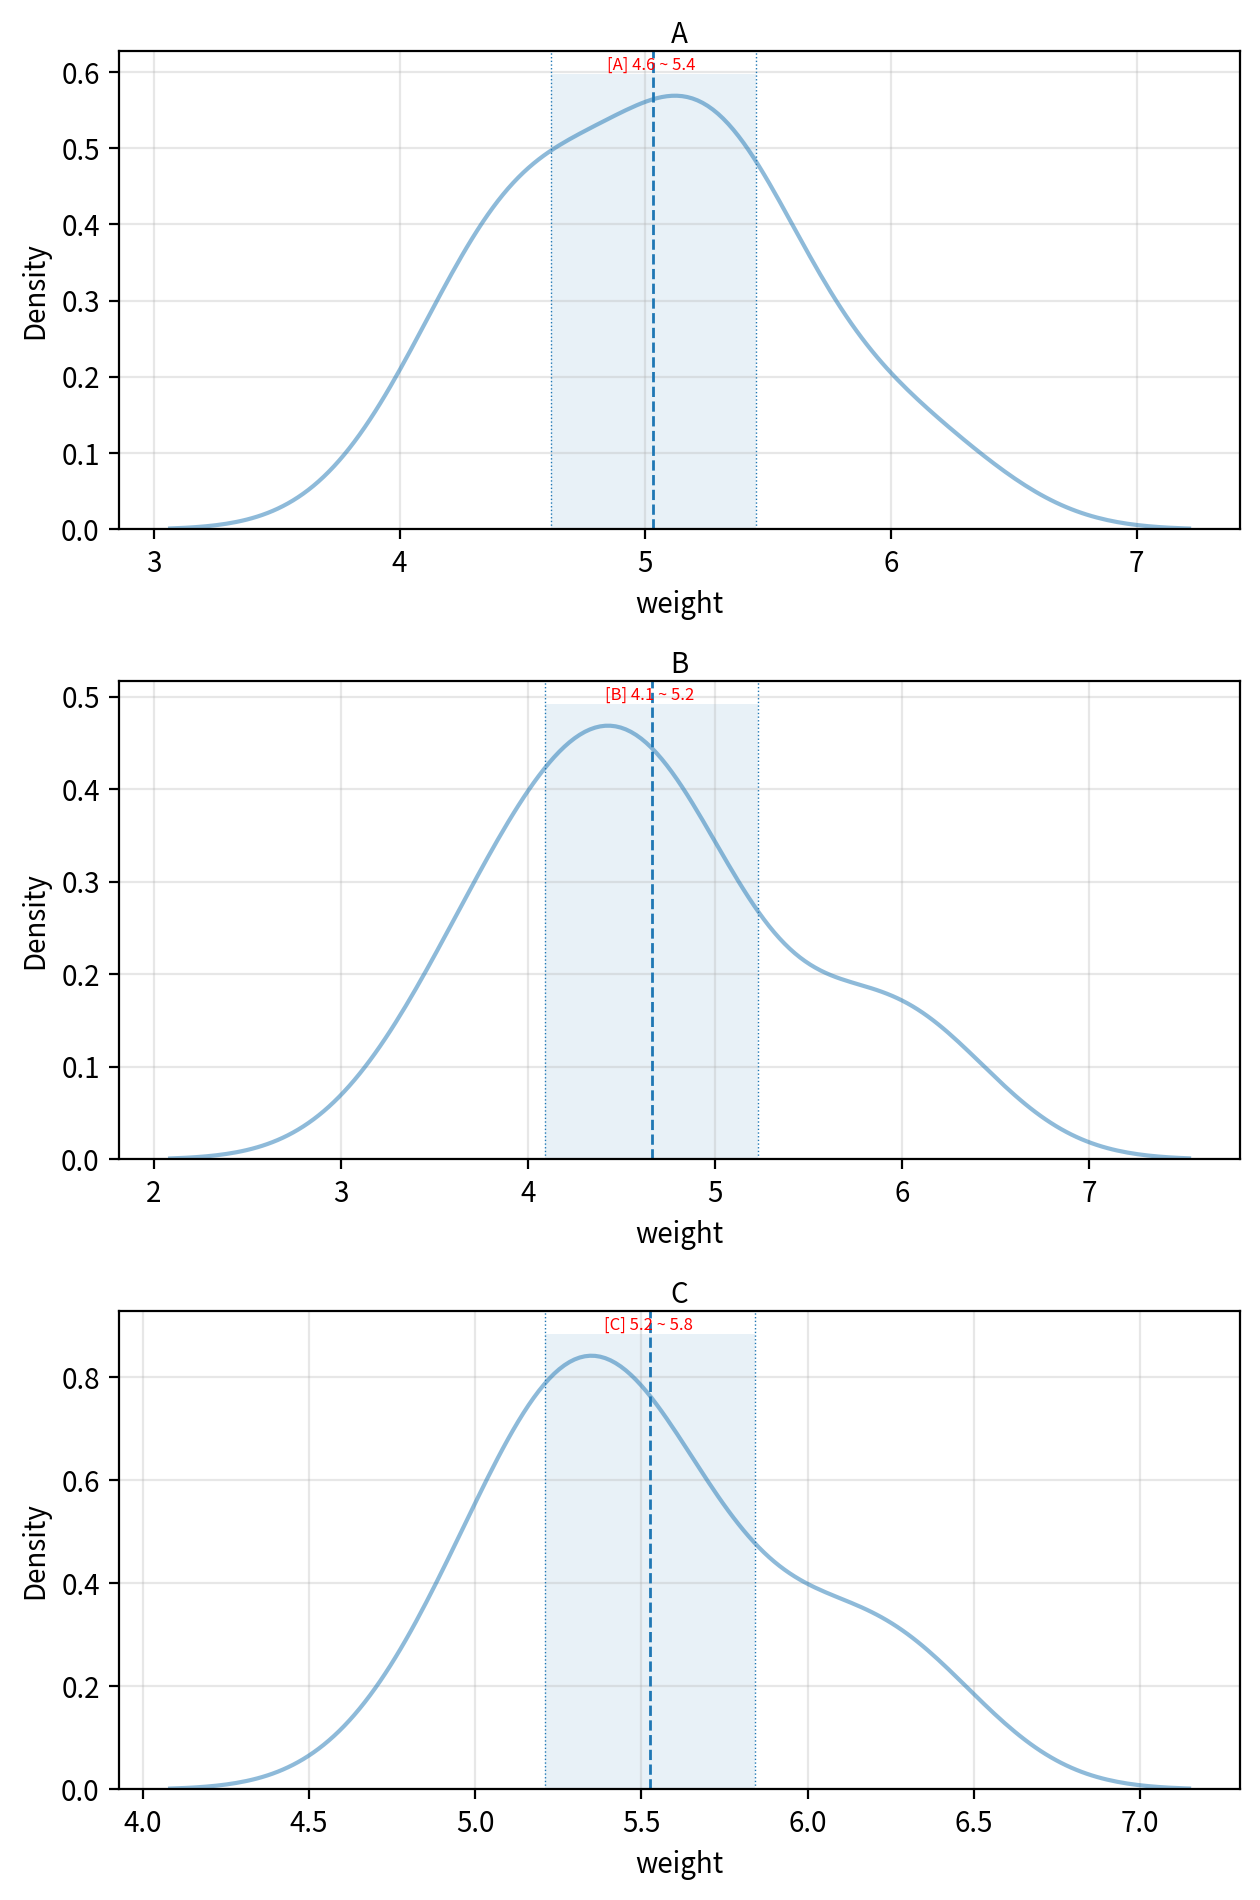

In [94]:
field = 'weight'
hue_field = 'group'
df = origin[[field, hue_field]]
hue_values = df[hue_field].unique()
hue_count = len(hue_values)

width_px = 1280
height_px = 640 * rows
rows = len(hue_values)
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(hue_values):
    temp = df[df[hue_field]== v]

    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    max = temp[field].max()
    clevel = 0.95
    dof = len(temp[field]) - 1
    sp_mean = temp[field].mean()
    sp_std = temp[field].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(temp[field]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (v, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()




In [95]:
field = 'weight'
hue_field = 'group'
df = origin.filter([field, hue_field])
df['idx']= df.groupby(hue_field).cumcount()
data = pivot_table(df, index='idx', columns=hue_field, values = field)
data

group,A,B,C
idx,,,
0,4.17,4.81,6.31
1,5.58,4.17,5.12
2,5.18,4.41,5.54
3,6.11,3.59,5.50
4,4.50,5.87,5.37
5,4.61,3.83,5.29
6,5.17,6.03,4.92
7,4.53,4.89,6.15
8,5.33,4.32,5.80


In [96]:
equal_var_fields = []
normal_dist = True
report = []
values = []

for c in data.columns:

    target = data[c].dropna()
    values.append(target)
    s,p = normaltest(target)

    normalize = p>0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize


if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"

        s,p = bartlett(*values)

    else:
        n = "Levene"

        s,p = levene(*values, center='median')
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p>0.05
    })
    equal_var = p>0.05

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
Bartlett,2.878574,0.237097,True


In [97]:
field = 'weight'
hue_field = 'group'
anova_df = origin[[field, hue_field]]

if equal_var:
    pg_anova= anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field,between=hue_field)

display(pg_anova)

f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
display("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val,p_val, "대립" if p_val <= 0.05 else "귀무"))

if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv =field,between=hue_field)

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


'statistic: 4.846, p-value: 0.016, 대립가설 채택'

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


C가 가장 크고,B가 가장 작다.
A&B A가 더 무겁지만 차이는 통계적으로 유의하지 않음
A&C C가 더 무겁지만 유의성 부족
B&C C가  B보다 유의하게 더 무거움
C집단의 소나무는 B집단보다 통계적으로 유의하게 더 무겁다.
A집단은 B,C어느 쪽과도 유의미한 차이를 보이지 않는다.

문제 2번
reading데이터셋은 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수 데이터이다.
세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

In [98]:
origin = load_data('reading')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인=====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/reading.xlsx
[desc] 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90, 2)
열 개수: 2
행 개수: 90

===== 타입확인=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   독서방법    90 non-null     object 
 1   점수      90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB
None


,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


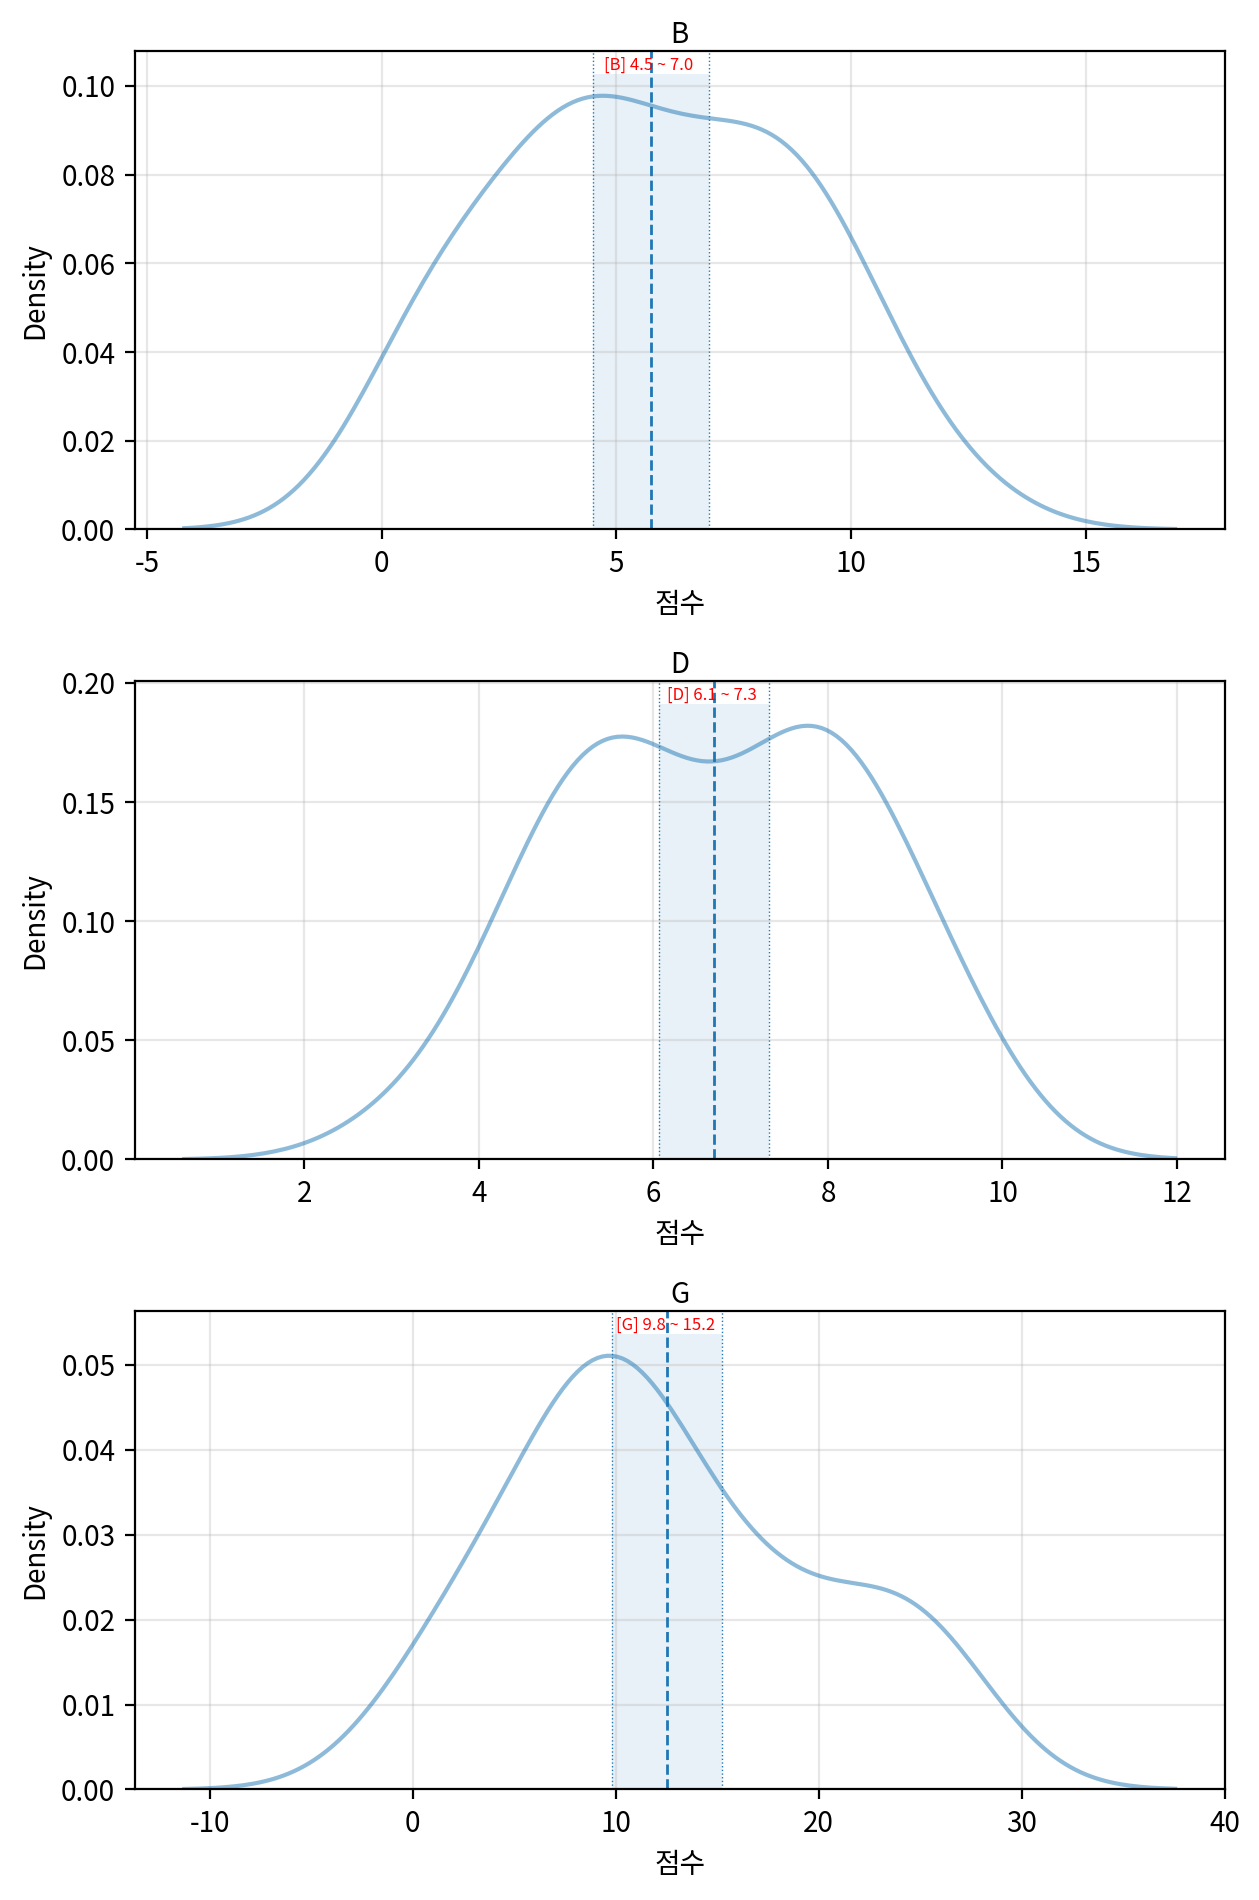

In [99]:
field = '점수'
hue_field = '독서방법'
df = origin[[field, hue_field]]
hue_values = df[hue_field].unique()
hue_count = len(hue_values)

width_px = 1280
height_px = 640 * rows
rows = len(hue_values)
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(hue_values):
    temp = df[df[hue_field]== v]

    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    max = temp[field].max()
    clevel = 0.95
    dof = len(temp[field]) - 1
    sp_mean = temp[field].mean()
    sp_std = temp[field].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(temp[field]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
            s="[%s] %0.1f ~ %0.1f " % (v, cmin, cmax), horizontalalignment="center",
            verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()




In [100]:
field = '점수'
hue_field = '독서방법'
df = origin.filter([field, hue_field])
df['idx']= df.groupby(hue_field).cumcount()
data = pivot_table(df, index='idx', columns=hue_field, values = field)
data.head()

독서방법,B,D,G
idx,,,
0,7.7,9.4,10.6
1,1.5,9.4,9.2
2,4.3,4.4,8.9
3,5.4,3.2,15.7
4,4.3,5.7,0.0


In [ ]:
equal_var_fields = []
normal_dist = True
report = []
values = []

for c in data.columns:

    target = data[c].dropna()
    values.append(target)
    s,p = normaltest(target)

    normalize = p>0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,+ 
        "result": normalize
    })
    normal_dist = normal_dist and normalize


if len(data.columns)>1:
    if normal_dist:
        n = "Bartlett"

        s,p = bartlett(*values)

    else:
        n = "Levene"

        s,p = levene(*values, center='median')
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p>0.05
    })
    equal_var = p>0.05

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
B,2.210100,3.311943e-01,True
D,2.396634,3.017015e-01,True
G,2.216900,3.300701e-01,True
Bartlett,58.099241,2.420528e-13,False


In [102]:
field = '점수'
hue_field = '독서방법'
anova_df = origin[[field, hue_field]]

if equal_var:
    pg_anova= anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field,between=hue_field)

display(pg_anova)

f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
display("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val,p_val, "대립" if p_val <= 0.05 else "귀무"))

if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv =field,between=hue_field)

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


'statistic: 10.787, p-value: 0.000, 대립가설 채택'

=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,B,D,5.732143,6.693333,-0.961190,0.676594,-1.420631,40.563109,0.339976,-0.375556
1,B,G,5.732143,12.531250,-6.799107,1.457054,-4.666340,42.964012,0.000088,-1.136960
2,D,G,6.693333,12.531250,-5.837917,1.362766,-4.283874,34.360873,0.000403,-1.043650


1.분산분석 결과: p<0.001이므로 귀무가설(세 집단의 평균이 동일하다)을 기각하고 대립가설(적어도 한 집단은 평균이 다르다)을 채택한다.
효과크기 np^2=0.283->중간에서 큰 효과크기, 즉 읽기방법이 학습 성과에 상당한 영향력을 가짐.
2.집단G는 B와D 모두보다 매우 높은 독서평가 점수를 기록함.
집단 G가 가장 높은 점수, B가 가장 낮은 점수를 보임.
3.
4.